In [1]:
!nvidia-smi

Tue Oct 29 15:24:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

**Initialize**

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.utils import class_weight
from sklearn.model_selection import KFold
import time
import os
import shutil

read_file=scipy.io.loadmat('2channel_input_PRRB.mat') # Read data
Input = np.zeros((2100,450,2)) # Data size

Input[:,:,0] =np.array(read_file['three_channel_Input_data'])[:,:,0]
Input[:,:,1] =np.array(read_file['three_channel_Input_data'])[:,:,1]

label =np.array(read_file['label']) 
X = Input
Y = label


# number of class
n_classes= 42
# number of features
n_features=X.shape[1]

print(X.shape, Y.shape)

print(n_features)



(2100, 450, 2) (2100, 1)
450


**Set Target Subject**

In [3]:
### Target ID: ?(1-42) 

ID = 1
print('ID',ID)

Y[np.where(Y!=ID)] = 0
   

ID 1


In [4]:
print(np.unique(Y, return_counts=True)) # Check whether target has 1, while others are 0


(array([0, 1], dtype=uint8), array([2050,   50]))


**Onehot Encoding + Data spliting and suffle**

In [5]:
enc = OneHotEncoder()
# randomly shuffle data before training and testing

randIndx = np.arange(X.shape[0])
np.random.seed(111)
np.random.shuffle(randIndx)

# 60% for training and 40% for testing
trainSamples=np.floor(X.shape[0]*0.6).astype(int)
testSamples=np.floor(X.shape[0]*0.4).astype(int) 


print(trainSamples)
print(testSamples)

X = X[randIndx,:,:] 
 
Y =enc.fit_transform(Y[randIndx].reshape(-1,1)).toarray() 



1260
840


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
print(np.unique(Y[:,1], return_counts=True))


(array([0., 1.]), array([2050,   50]))


In [7]:
# Assign training and testing set
nChannels=2

train_data, train_target = X[:trainSamples,:,:], Y[:trainSamples,:]
test_data, test_target = X[trainSamples:,:,:], Y[trainSamples:,:]



print(train_data.shape,train_target.shape)
print(test_data.shape,test_target.shape)


(1260, 450, 2) (1260, 2)
(840, 450, 2) (840, 2)


In [8]:
# Check # of 1 and 0 in training and testing set

unique, counts = np.unique(train_target[:,1], return_counts=True)
print('Train set dictionary: ',dict(zip(unique, counts)))

unique, counts = np.unique(test_target[:,1], return_counts=True)
print('Test set dictionary: ',dict(zip(unique, counts)))



Train set dictionary:  {0.0: 1230, 1.0: 30}
Test set dictionary:  {0.0: 820, 1.0: 20}


**Network Structure**

In [0]:
class Model:

    def __init__(self, sess, name):

        self.sess = sess

        self.name = name

        self._build_net()

    def _build_net(self):

        with tf.variable_scope(self.name):

            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing

            self.training = tf.placeholder(tf.bool)
    
            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 450, 2]) 
            self.Y = tf.placeholder(tf.float32, [None, 2])
            self.class_weights = tf.placeholder(tf.float32) # For weighted loss
            self.learning_rate = tf.placeholder(tf.float32)
            
            # Convolutional Layer #1, length: 450x2 -> 361x30  ((I-F)/S) + 1 
            W1 = tf.Variable(tf.random_normal([90, 2, 30], stddev=0.01))
            conv1 = tf.nn.conv1d(self.X, W1, stride=1, padding='VALID')
            relu1 = tf.nn.relu(conv1) # max(0,x)
            dropout1 = tf.layers.dropout(inputs=relu1, rate=0.5, training=self.training)
            
            # Convolutional Layer #2, length: 361x30 -> 242x50 
            W2 = tf.Variable(tf.random_normal([120, 30, 50], stddev=0.01))
            conv2 = tf.nn.conv1d(dropout1, W2, stride=1, padding='VALID')
            relu2 = tf.nn.relu(conv2)                                    
            dropout2 = tf.layers.dropout(inputs=relu2, rate=0.5, training=self.training)
            
            # Convolutional Layer #3, length: 242x50 -> 93x70 
            W3 = tf.Variable(tf.random_normal([150, 50, 70], stddev=0.01))
            conv3 = tf.nn.conv1d(dropout2, W3, stride=1, padding='VALID')
            relu3 = tf.nn.relu(conv3)                                    
            dropout3 = tf.layers.dropout(inputs=relu3, rate=0.5, training=self.training)
        
            # FC 1, length: 33x70  -> 2 output
            FC1 = tf.reshape(dropout3, [-1, 93*70])         
            FC_weight = tf.get_variable("FC_weight", shape=[93*70, 2], initializer=tf.contrib.layers.xavier_initializer())
            logits = tf.matmul(FC1,FC_weight)

    
        # define cost/loss & optimizer   
        reg_losses = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) + tf.nn.l2_loss(FC_weight)
        reg_constant = 0.1  # Choose an appropriate one.
    
        self.cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.Y, logits, self.class_weights)) 
        self.cost = self.cost + reg_constant * reg_losses
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost) 
#         self.optimizer = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.cost)    
        
        self.sigmoid_out = tf.nn.sigmoid(logits) # logit 결과를 0과 1 사이로 squeeze
        self.predict = tf.cast(self.sigmoid_out[:,1], tf.float32)
                    
        self.weight1 = W1
        self.weight2 = W2
        self.weight3 = W3
        
    def get_predict(self, x_test, training=False):          

        return self.sess.run(self.predict, feed_dict={self.X: x_test, self.training: training})
    

    def get_cost(self, x_valid, y_valid, weights, training=False):
        
        return self.sess.run(self.cost, feed_dict={self.X: x_valid, 
                                                   self.Y: y_valid, self.class_weights: weights, self.training: training})


    def train(self, x_data, y_data, weights, learning, training=True):

        return self.sess.run(self.optimizer, feed_dict={
             self.X: x_data, self.Y: y_data, self.class_weights: weights, self.learning_rate: learning, self.training: training})
    
    def plot_feature(self, x_data, y_data, training=False):
        
        return self.sess.run(self.weight1, feed_dict={self.X: x_data, self.Y: y_data, self.training: training})
    
    def plot_feature2(self, x_data, y_data, training=False):
        
        return self.sess.run(self.weight2, feed_dict={self.X: x_data, self.Y: y_data, self.training: training})
    
    def plot_feature3(self, x_data, y_data, training=False):
        
        return self.sess.run(self.weight3, feed_dict={self.X: x_data, self.Y: y_data, self.training: training})

**Main**

In [10]:
### hyper parameters

learning_rate = 0.0001
training_epochs = 30
batch_size = 126 # Mini-batch size: total: 1260(train)/840(test)  
num_cv = 10 #  Number of fold cross validation
bag_size = 1134 # Each bagging size
ear_epoch = 0

valid_cost = np.zeros((training_epochs))
train_cost = np.zeros((training_epochs))

# initialize
sess = tf.Session()

models = []
num_models = 3 # Number of models for bagging

for m in range(num_models):
    print('Number of Model+Bagging {}'.format(m+1))
    models.append(Model(sess, "model" + str(m)))    

sess.run(tf.global_variables_initializer())

#saver = tf.train.Saver()

start_time = time.time() # time starts!

print('Learning Started!')

# train my model
for epoch in range(training_epochs):
         
    total_batch = int(bag_size / batch_size)
    valid_cost_cv = 0
    
    cv = KFold(n_splits=num_cv, shuffle=True)
    for train_index, test_index in cv.split(train_data):
        cv_train_data, cv_validate_data = train_data[train_index], train_data[test_index]
        cv_train_target, cv_validate_target = train_target[train_index], train_target[test_index]    
                    
        for m_idx, m in enumerate(models):
            bag_index = np.random.choice(len(cv_train_target), bag_size, replace=True) # Random sampling with replacement
            #print(bag_index)
            bag_cv_train_data = cv_train_data[bag_index,:]
            bag_cv_train_target = cv_train_target[bag_index,:] 

            for i in range(total_batch):

                batch_xs, batch_ys = bag_cv_train_data[batch_size*i:batch_size*(i+1),:], bag_cv_train_target[batch_size*i:batch_size*(i+1)]                
                pos_weight = (n_classes - 1) # Increase Sensitivity(FN down) and Decrease Specifity (FP up)

                _ = m.train(batch_xs, batch_ys, pos_weight, learning_rate)    
                
                pos_weight = 1
#                 train_cost[epoch] += m.get_cost(batch_xs, batch_ys, pos_weight) / (num_cv * num_models * total_batch) #train_cost
            
            
            valid_cost_cv += m.get_cost(cv_validate_data, cv_validate_target, pos_weight)  #valid_cost 
            
    valid_cost[epoch] = valid_cost_cv / (num_cv * num_models) # valid_cost for cross validation
    
    if ((epoch+1)%5) == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'Validating_cost =', '{:.5f}'.format(valid_cost[epoch]))
#         print('Epoch:', '%04d' % (epoch + 1), 'Training_cost =', '{:.5f}'.format(train_cost[epoch]))
           
            
    if valid_cost[epoch] < 0.01:
        print('Early Stopping, Epoch: ', epoch+1)
        ear_epoch = epoch+1
        break
        
        
print('Learning Finished!')


end_time = time.time() # time ends!

elapsed = end_time - start_time

print('Execution time:{:.2f} seconds'.format(elapsed))
print('Last validation error:{:.3f} '.format(valid_cost[-1]))
#saver.save(sess, 'SingleSession\Model\m'+str(ID)) # Model Save


pos_weight = 1 # No weighted loss because no more training

Number of Model+Bagging 1
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Number of Model+Bagging 2
Number of Model+Bagging 3
Learning Started!
Epoch: 0005 Validating_cost = 1.07118
Epoch: 0010 Validating_cost = 0.34030
Epoch: 0015 Validating_cost = 0.16125
Epoch: 0020 Validating_cost = 0.10306
Epoch: 0025 Validating_cost = 0.07528
Epoch: 0030 Validating_cost = 0.05851
Learning Finished!
Execution time:339.54 seconds
Last validation error:0.059 


**Epoch vs Cost plot**

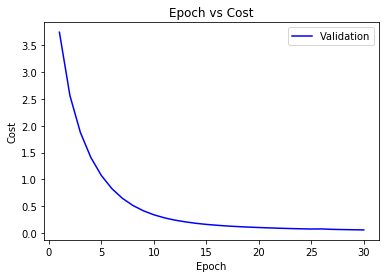

In [11]:
fig = plt.figure()
ax = plt.subplot(111)

if ear_epoch == 0: # No early stop
    x_axis = np.linspace(1.0, training_epochs, num=training_epochs)
#     ax.plot(x_axis, train_cost, 'b', label='Training')
    ax.plot(x_axis, valid_cost,'b', label='Validation')
else: # Yes early stop
    x_axis = np.linspace(1.0, ear_epoch, num=ear_epoch)
#     ax.plot(x_axis, train_cost[:ear_epoch], 'b', label='Training')
    ax.plot(x_axis, valid_cost[:ear_epoch],'b', label='Validation')

ax.legend()
plt.title('Epoch vs Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')

plt.show()



**Final Result of train set**

In [12]:
thres = np.arange(0, 1.0001, 0.0001)
thres_matrix_train = np.zeros((len(train_target),len(thres)))
total_matrix_train = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)
    
test_logit2_temp = np.zeros((len(train_target), num_models))
train_cost2 = 0

for m3_idx, m3 in enumerate(models):
    test_logit2_temp[:,m3_idx] =  m3.get_predict(train_data)

    if test_logit2_temp[np.where(test_logit2_temp< 0)] < 0:
        print('Error')
    else:
        print('Okay, No minus values')       

    train_cost2 += m3.get_cost(train_data,train_target,pos_weight) / num_models

print('Train set Cost:{:.3f}'.format(train_cost2))

test_logit2 = np.mean(test_logit2_temp, axis=1)

for j in range(len(thres)):
    for i in range(len(train_target)):
        if test_logit2[i] < thres[j]:
            thres_matrix_train[i,j] = 0
        else:
            thres_matrix_train[i,j] = 1


unique, counts = np.unique(train_target[:,1], return_counts=True)
print('Train set dictionary: ',dict(zip(unique, counts)))

for i in range(len(thres)):

    equal_logit2 = np.equal(thres_matrix_train[:,i], train_target[:,1]) ##Train
    unique2, True_pos_neg_train = np.unique(thres_matrix_train[np.where(equal_logit2==True),i], return_counts=True)
    unique3, False_pos_neg_train = np.unique(thres_matrix_train[np.where(equal_logit2==False),i], return_counts=True) 

    if np.shape(True_pos_neg_train)==(1,):
        if unique2[0] == 0:
            True_pos_neg_train = [True_pos_neg_train[0], 0]
        else:
            True_pos_neg_train = [0, True_pos_neg_train[0]]

    if np.shape(False_pos_neg_train)==(1,):
        if unique3[0] == 0:
            False_pos_neg_train = [False_pos_neg_train[0], 0]
        else:
            False_pos_neg_train = [0, False_pos_neg_train[0]]
   
    if np.shape(True_pos_neg_train)==(0,):
        True_pos_neg_train = [0, 0]
        
    if np.shape(False_pos_neg_train)==(0,):
        False_pos_neg_train = [0, 0]
 
    Recall_train= True_pos_neg_train[1]/(False_pos_neg_train[0]+True_pos_neg_train[1])
    Specific_train = True_pos_neg_train[0] /(True_pos_neg_train[0]+False_pos_neg_train[1])

    ACC_train = (True_pos_neg_train[0]+True_pos_neg_train[1]) / (len(train_target))
    FAR_train = 1 - Specific_train
    FRR_train = 1 - Recall_train

    total_matrix_train[i,:] = ACC_train, FAR_train, FRR_train, Recall_train
    



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # This is added back by InteractiveShellApp.init_path()


Okay, No minus values
Okay, No minus values
Okay, No minus values
Train set Cost:0.057
Train set dictionary:  {0.0: 1230, 1.0: 30}


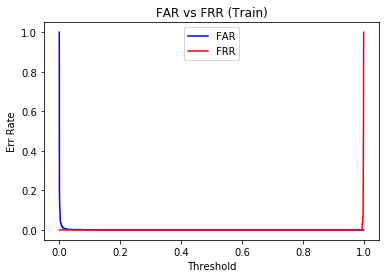

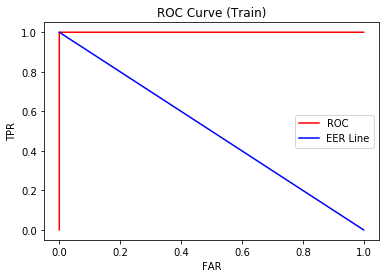

EER: 0.000 
FRR at EER: 0.000 
FAR at EER: 0.000 
Accuracy at EER: 1.000 


In [13]:
fig2 = plt.figure()
ax = plt.subplot(111)
ax.plot(thres, total_matrix_train[:,1], 'b', label='FAR')
ax.plot(thres, total_matrix_train[:,2], 'r', label='FRR')
ax.legend()
plt.title('FAR vs FRR (Train)')
plt.xlabel('Threshold')
plt.ylabel('Err Rate')
plt.show()

EER_line = thres[::-1]
fig3 = plt.figure()
ax2 = plt.subplot(111)
ax2.plot(total_matrix_train[:,1], total_matrix_train[:,3],'r',label='ROC')
ax2.plot(thres, EER_line, 'b',label='EER Line')
ax2.legend()
plt.title('ROC Curve (Train)')
plt.xlabel('FAR')
plt.ylabel('TPR')
plt.show()

EER_loc_train = np.argmin(abs(total_matrix_train[:,1] - total_matrix_train[:,2]))
# print('EER threshold: ', thres[EER_loc_train])
print('EER: {:.3f} '.format((total_matrix_train[EER_loc_train,1]+total_matrix_train[EER_loc_train,2])/2))
print('FRR at EER: {:.3f} '.format(total_matrix_train[EER_loc_train,2]))
print('FAR at EER: {:.3f} '.format(total_matrix_train[EER_loc_train,1]))
print('Accuracy at EER: {:.3f} '.format(total_matrix_train[EER_loc_train,0]))


**Final Result of test set**

In [14]:
thres = np.arange(0, 1.0001, 0.0001)

start_time_test = time.time() # time starts!

thres_matrix_test = np.zeros((len(test_target),len(thres)))
total_matrix_test = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)
    
test_logit_temp = np.zeros((len(test_target), num_models))
test_cost = 0

for m4_idx, m4 in enumerate(models):
    test_logit_temp[:,m4_idx] =  m4.get_predict(test_data)

    if test_logit_temp[np.where(test_logit_temp< 0)] < 0:
        print('Error')
    else:
        print('Okay, No minus values')       

    test_cost += m4.get_cost(test_data,test_target,pos_weight) / num_models

print('Test set Cost: {:.3f}'.format(test_cost))

test_logit = np.mean(test_logit_temp, axis=1)

for j in range(len(thres)):
    for i in range(len(test_target)):
        if test_logit[i] < thres[j]:
            thres_matrix_test[i,j] = 0
        else:
            thres_matrix_test[i,j] = 1


unique, counts = np.unique(test_target[:,1], return_counts=True)
print('Test set dictionary: ',dict(zip(unique, counts)))


for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_test[:,i], test_target[:,1]) ##Test
    unique2, True_pos_neg_test = np.unique(thres_matrix_test[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_test[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]
   
    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]
        
    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]
 
    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(test_target))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_test[i,:] = ACC_test, FAR_test, FRR_test, Recall_test
    
end_time_test = time.time() # time ends! 

elapsed = end_time_test - start_time_test

print('Execution Test time:{:.2f} seconds'.format(elapsed))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


Okay, No minus values
Okay, No minus values
Okay, No minus values
Test set Cost: 0.057
Test set dictionary:  {0.0: 820, 1.0: 20}
Execution Test time:7.33 seconds


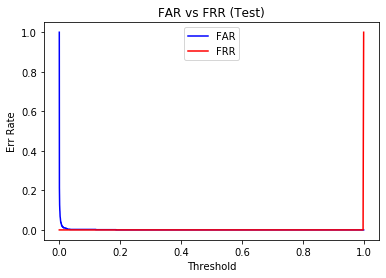

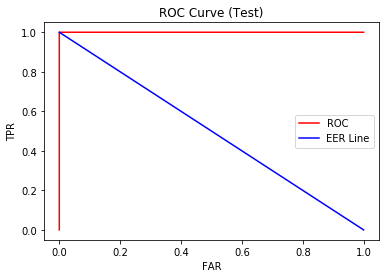

EER: 0.000 
FRR at EER: 0.000 
FAR at EER: 0.000 
Accuracy at EER: 1.000 


In [15]:
fig4 = plt.figure()
ax = plt.subplot(111)
ax.plot(thres, total_matrix_test[:,1], 'b', label='FAR')
ax.plot(thres, total_matrix_test[:,2],'r', label='FRR')
ax.legend()
plt.title('FAR vs FRR (Test)')
plt.xlabel('Threshold')
plt.ylabel('Err Rate')
plt.show()

EER_line = thres[::-1]
fig5 = plt.figure()
ax2 = plt.subplot(111)
ax2.plot(total_matrix_test[:,1], total_matrix_test[:,3],'r',label='ROC')
ax2.plot(thres, EER_line, 'b',label='EER Line')
ax2.legend()
plt.title('ROC Curve (Test)')
plt.xlabel('FAR')
plt.ylabel('TPR')
plt.show()

EER_loc_test = np.argmin(abs(total_matrix_test[:,1] - total_matrix_test[:,2]))
# print('EER threshold: ', thres[EER_loc_test])
print('EER: {:.3f} '.format((total_matrix_test[EER_loc_test,1]+total_matrix_test[EER_loc_test,2])/2))
print('FRR at EER: {:.3f} '.format(total_matrix_test[EER_loc_test,2]))
print('FAR at EER: {:.3f} '.format(total_matrix_test[EER_loc_test,1]))
print('Accuracy at EER: {:.3f} '.format(total_matrix_test[EER_loc_test,0]))



**Feature Visualization**

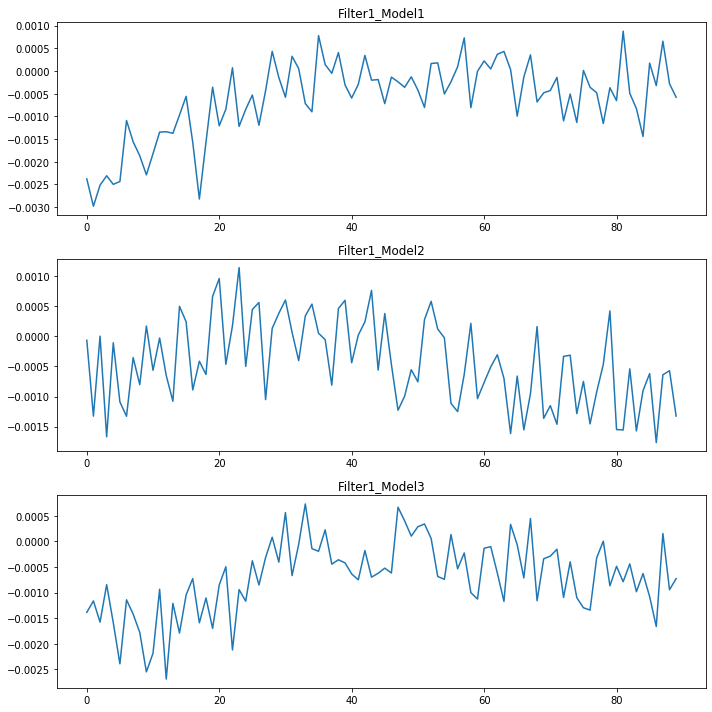

In [16]:
fig11= plt.figure(figsize=(10,10))
for m4_idx, m4 in enumerate(models):
    ax = fig11.add_subplot(num_models,1,m4_idx+1)
    plot_1 = m4.plot_feature(train_data, train_target)
    ax.plot(np.mean(np.mean(plot_1, axis=2),axis=1))
    plt.title('Filter1_Model'+str(m4_idx+1))
plt.tight_layout()
 
        

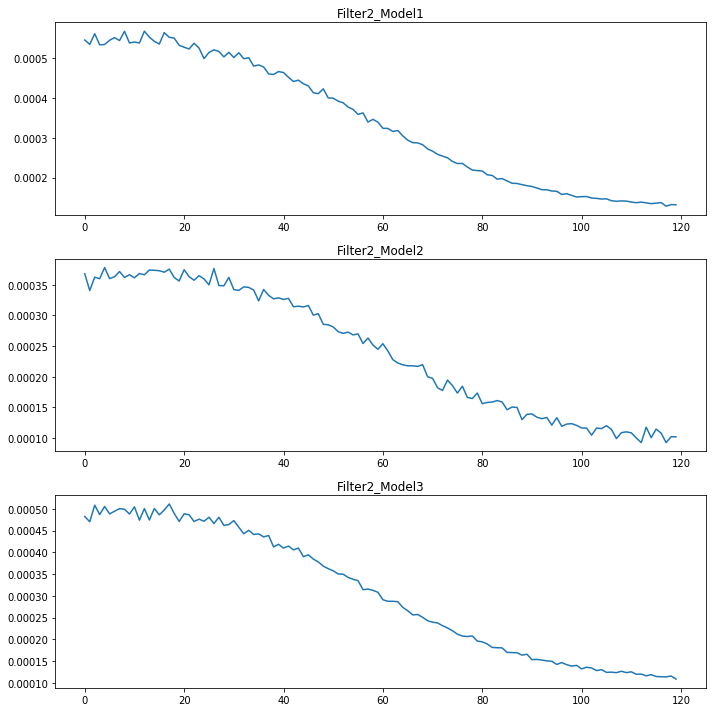

In [17]:
fig22= plt.figure(figsize=(10,10))
for m4_idx, m4 in enumerate(models):
    ax = fig22.add_subplot(num_models,1,m4_idx+1)
    plot2 = m4.plot_feature2(train_data, train_target)
    ax.plot(np.mean(np.mean(plot2, axis=2),axis=1))
    plt.title('Filter2_Model'+str(m4_idx+1))
plt.tight_layout()

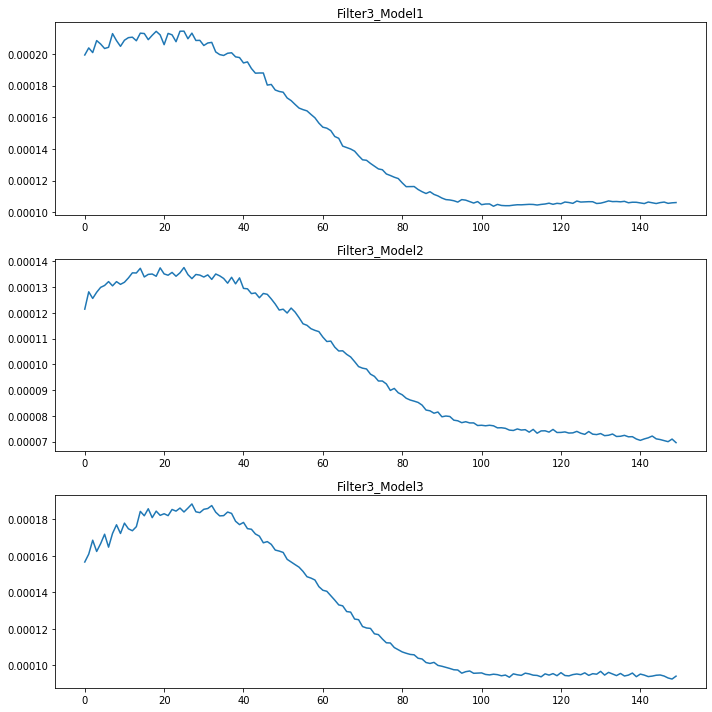

In [18]:
fig33= plt.figure(figsize=(10,10))
for m4_idx, m4 in enumerate(models):
    ax = fig33.add_subplot(num_models,1,m4_idx+1)
    plot3 = m4.plot_feature3(train_data, train_target)
    ax.plot(np.mean(np.mean(plot3, axis=2),axis=1))
    plt.title('Filter3_Model'+str(m4_idx+1))
plt.tight_layout()